# How PSPNet works?

### Introduction

In the guide [How u-net works](https://developers.arcgis.com/python/guide/how-unet-works/), we have learned how to solve the problem of semantic segmentation using deep learning architecture called Unet using the ArcGIS Python API. There are many other semantic segmentation algorithms like PSPNet, Deeplab, etc. In this guide, we will mainly focus on Pyramid scene parsing network (PSPNet) [1] which is one of the most well-recognized image segmentation algorithms as it won  ImageNet Scene Parsing Challenge 2016 and its paper has more than 1500 citations. PSPNet is another semantic segmentation model along with the Unet that has been implemented into the `arcgis.learn` module which can be trained to classify pixels in a raster.

Note: To follow the guide below, we assume that you have some basic understanding of deep learning and the convolutional neural networks (CNNs). You can learn about deep learning by going through these Stanford University's CS231n [course notes](http://cs231n.github.io/convolutional-networks/).

### Why PSPNet architecture is better than FCN based segmentation?

The PSPNet architechture takes into account the global context of the image to predict the local level predictions hence gives better performance on benchmark datasets like PASCAL VOC 2012 and cityscapes. The model was needed because FCN based pixel classifiers were not able to capture the context of the whole image.

Let's understand through an example below:

<figure>
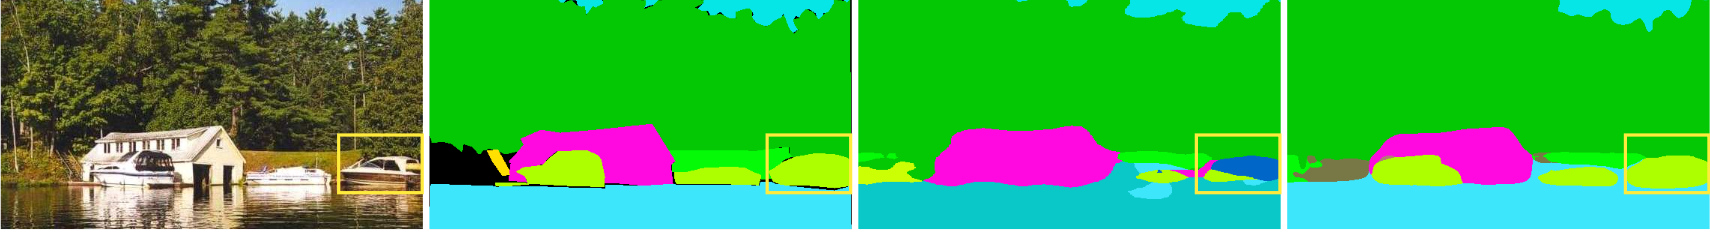

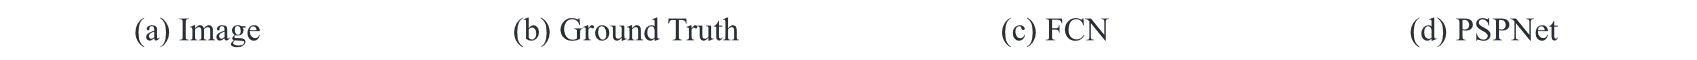
<center><figcaption>Image comparing FCN and PSPNet [1]</figcaption></center>
</figure>

The boat inside the yellow bounding box in (a) is classified as a "car" by a FCN based classifier (c). It is because of its shape and appearance. But it is uncommon to see a car in river. If the model could gain information from the context, for example in our case water around the object, it will be able to correctly classify it. The PSPNet model (d) is able to capture the context of the whole image to classify the object as a boat (Green).

## Encoder-Decoder Architecture for Semantic Segmentation

Most semantic segmentation model contains two parts, i.e an Encoder and a Decoder. The Encoder is responsible for the extracting out features from the image, the decoder is the one which predicts the class of the pixel at the end. A typical Encoder-Decoder for segmentation task looks like the below architecture.

<figure>
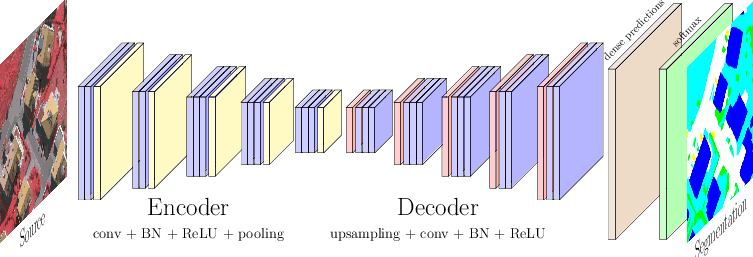
<center>
    <figcaption>Encoder-Decoder Networks for Semantic Segmentation [6]</figcaption>
</center>
</figure>

### PSPNet Encoder

#### Dilated Convolutions

In the last layers of the backbone, we replace the traditional convolutional layers with [Dilated convolution](https://arxiv.org/abs/1705.09914) layers, which helps in increasing the receptive field. This Dilated convolution layers are placed in the last two blocks of the backbone. Hence the feature recieved at the end of the backbone contains richer features.
The illustration[2] shows what dilated convolutions do and how is it different from convolutions.

<figure>
        <img src="../../static/img/dilated.gif", align="left">
        <img src="../../static/img/normal_convolution.gif">
<center>
    <figcaption>Animation of convolution with dilation=2 (left) and dilattion=1(Right). When dilation=1, it is just the standard convolution operation. [2]</figcaption>
</center>
</figure>

The value of dilation specifies the sparsity while doing the convolution. We can see that the receptive field for dilated convolution is larger as compared to the standard convolution. The size of the receptive field indicates how much we use context information. In PSPNet, the last two blocks of the backbone are dilated with dilation values 2 and 4 respectively.

#### Pyramid Pooling Module

The pyramid pooling module is the main part of this model as it helps the model to capture the global context in the image which helps it to classify the pixels based on the global information present in the image. 

<figure>
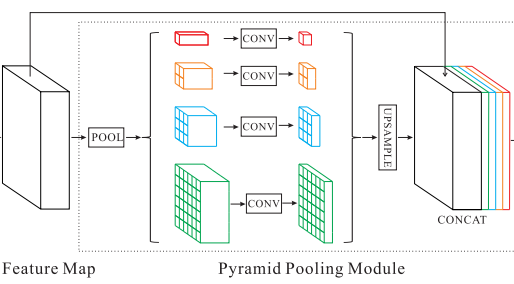
<center><figcaption>PSPNet Architecture [1]</figcaption></center>
</figure>

The feature map from the backbone is pooled at different sizes and then passed through a convolution layer and after which upsampling takes place to make them the same size as of the original feature map. Finally, the upsampled maps are concatenated with the original feature map to be passed to the decoder. This technique fuses the features at four different scales, which you can pass as a parameter to the `PSPNetClassifier` model. The four levels are a defined from coarse to fine. Suppose if we pool the features at scales of (1, 3, 5, 6). The first is the most coarse feature map as it captures all the information in just 1x1 spatial location, whereas as the spatial resolution increases, the high resolution features are also taken in account as in the case of 6x6 pyramid size. A rule of thumb is that the if the pyramid size is small i.e ~1 or 2, the model will capture the low resolution and bigger features whereas if the  the pyramid size is bigger i.e ~6-8, the model will be able to capture high resolution features.
So, if we have a large variance in the size of features to be segmented, we might want to increase the number of pyramids and the size of pyramids in the PSPNet module, on the other hand if we have similiar sized features, we can get away with only one or two level pyramid.

### PSPNet Decoder

The PSPNet model is  not a complete segmentation model in itself, it is just an encoder, which means it is just half of what is required for image segmentation. The most common decoders that are found in various implementations of PSPNet is a convolution layer followed by a 8x bilinear-upsampling.

<figure>
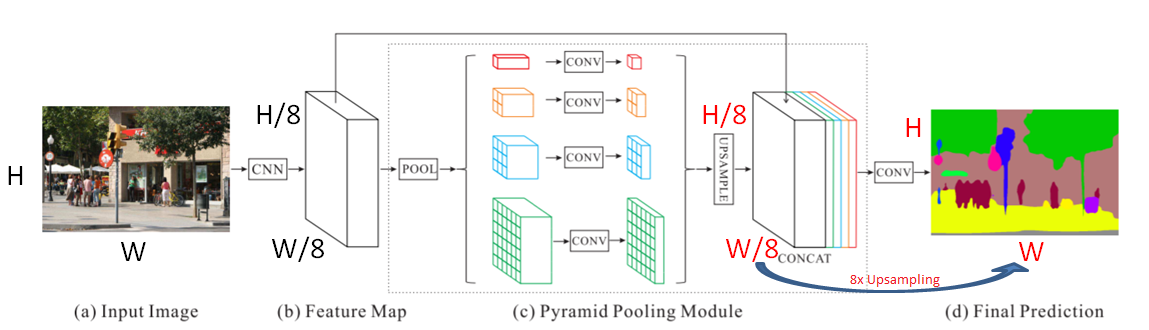
<center>
    <figcaption>PSPNet with 8x upsampling decoder [7]</figcaption>
</center>
</figure>

There is a downside of having a 8x upsmapling in the end is that there is no learnable layers hence the results that we get are blobs as results and fails to capture high resolution detailed information.

### PSPNet with U-Net like decoder

Now, to have the high resolution output from the model, we need to have a decoder which is has learnable parameters and can take input the high resolution feature maps as the input.

<figure>
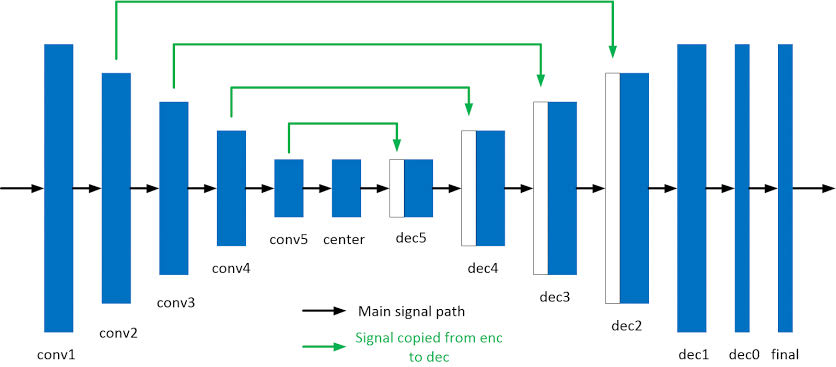
<center>
    <figcaption>Skip connections from encoder to form UNet like decoder. [4]</figcaption>
</center>
</figure>

To achieve that we turned to the feature pyramid networks (FPN), which is was the U-Net architechture [3] looks like. So, we added the UNet-like decoder to the PSPNet encoder, which can capture the smaller features in the image and is capable of capturing the small features from the image.

You can now create a FPN decoder with PSPNet by passing in `use_net=True` and viceversa.

To create a pspnet classifier with FPN decoder.

`psp = PSPNetClassifier(data)` Here data is fastai databunch, object returned by `prepare_data` function and to create pspnet classifier without FPN deocder.

`psp = PSPNetClassifier(data, use_unet=False)`

Then we can continue with the basic `arcgis.learn` workflow.

### References

[1] H. Zhao, J. Shi, X. Qi, X. Wang, and J. Jia.  Pyramid sceneparsing network.arXiv:1612.01105, 2016

[2] Sik-Ho Tsang https://towardsdatascience.com/review-dilated-convolution-semantic-segmentation-9d5a5bd768f5

[3] Olaf Ronneberger, Philipp Fischer: “U-Net: Convolutional Networks for Biomedical Image Segmentation”, 2015; [http://arxiv.org/abs/1505.04597 arXiv:1505.04597].

[4] Nan Zhang's http://goldsequence.blogspot.com/2018/11/a-pytorch-implementation-of-image.html

[5] Hengshuang Zhao https://github.com/hszhao/PSPNet

[6] Blog https://www.hackevolve.com/image-segmentation-using-deep-learning/

[7] kazucmpt https://github.com/hszhao/PSPNet/issues/101

[8] Fisher Yu, Vladlen Koltun: “Dilated Residual Networks”, 2017